In [2]:
import os

#is the notebook running on Colab?
if 'COLAB_JUPYTER_TRANSPORT' in os.environ.keys():
    isColab = True
    sourcedir =os.getcwd()+ "/CPlantBox"
    filedir = sourcedir +"/tutorial/jupyter/fspm_2023"
else:
    isColab = False
    sourcedir = os.getcwd()+"/../../.."
    filedir = os.getcwd()
#this can take some minutes
if isColab:
    # downloading the source code
    ! git clone https://github.com/Plant-Root-Soil-Interactions-Modelling/CPlantBox --depth=1 --single-branch -b stable_v2.1
    os.chdir(sourcedir)
    !apt install libeigen3-dev
    ! apt install llvm-dev
    !pip3 install vtk
    !sudo DEBIAN_FRONTEND=noninteractive apt-get install -yq xvfb
    !pip install -q 'xvfbwrapper~=0.2.9'
    if 'vdisplay' not in globals():
        # start a virtual X display for MAGICAL rendering
        import xvfbwrapper
        vdisplay = xvfbwrapper.Xvfb()
        vdisplay.start()
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"


    if os.path.exists("./src/external/pybind11"):
        ! rm -rf src/external/pybind11 #delete folder
    ! git rm -r --cached src/external/pybind11 #take out git cache for pybind11
    ! git submodule add --force -b stable https://github.com/pybind/pybind11.git ./src/external/pybind11


    ! git pull
    ! cmake .
    ! make
    os.chdir(filedir)

# Workshop 6.2024 - (4/4)

## Simulation of water movement in roots and soil domain using DuMux-Rosi

We couple the xylem water movement to a dynamic soil. We sequentially solve (a) root xylem water movement, and (b) soil water movement. Therefore, a rather small coupling time step is needed. 

Soil water movement is described by the Richards equation, and the van Genuchten model. We use DuMux to numerically solve these equation (i.e. the Python binding of DuMux-Rosi). 

We start with some additional imports, making the Richards solver available.

In [4]:
from IPython.display import SVG, display # to show svg files in the notebook

import sys; sys.path.append(sourcedir); sys.path.append(sourcedir+"/src")
import plantbox as pb
import visualisation.vtk_plot as vp # for quick 3d vizualisations
from functional.xylem_flux import XylemFluxPython  # Python hybrid solver
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../../../../dumux-rosi/build-cmake/cpp/python_binding/")
sys.path.append("../../../../dumux-rosi/python/modules/")
sys.path.append("../../../../dumux-rosi/python/modules/fv/")
from rosi_richards import RichardsSP  # C++ part (Dumux binding)
from richards import RichardsWrapper  # Python part
from rhizo_models import plot_transpiration

def sinusoidal(t):
    return np.sin(2. * np.pi * np.array(t) - 0.5 * np.pi) + 1.

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


We start with the simulation parameters (for a static root system)

In [5]:
min_b = [-1., -3., -25.] # [cm]
max_b = [1., 3., 0.] # [cm]
cell_number = [3, 5, 25]    
periodic = False # make the domain periodic or not
loam = [0.08, 0.43, 0.04, 1.6, 50]
soil = loam
initial = -600 # mean total soil potential [cm]
trans = 6.4  # [cm3 /day] (sinusoidal)
wilting_point = -10000  # [cm]
kz = 4.32e-2  # axial conductivity [cm3/day]
kr = 1.728e-4  # radial conductivity [1/day]
sim_time = 5 # [day] simulation time
dt = 120. / (24 * 3600)  # [day] time step must be very small
initial_age = 15 # [day] initial root age

The root system is calculated as before but with a confining geometry (if not periodic)

In [7]:
rs = pb.MappedRootSystem() # handles conductivity and mapping to the soil cells
path = "../../../modelparameter/structural/rootsystem/"
name = "Anagallis_femina_Leitner_2010" 
rs.readParameters(path + name + ".xml")
random_parameters = rs.getRootRandomParameter()
for p in random_parameters[1:]:
    p.dx = 0.25 
if periodic:    
    rs.setGeometry(pb.SDF_PlantBox(1.e6, 1.e6, max_b[2]-min_b[2]-0.1)) # we make it smaller by 0.1 cm, to make sure no root stick out
else:
    rs.setGeometry(pb.SDF_PlantBox(max_b[0]-min_b[0]-0.1, max_b[1]-min_b[1]-0.1, max_b[2]-min_b[2]-0.1)) # we make it smaller by 0.1 cm, to make sure no root stick out 
rs.initialize() # note that an artificial root of type 0 is added by MappedRootSystem
rs.simulate(initial_age)
ana = pb.SegmentAnalyser(rs.mappedSegments())
if periodic: 
    ana.mapPeriodic(max_b[0]-min_b[0], max_b[1]-min_b[1])
_ = vp.plot_roots(ana, "subType") 

OrganRandomParameter::readSuccessor: for parameter of organ 2, subType 1, 'ruleId' (and 'number') not found in successor definition. Use defeault ruleId instead: 0
OrganRandomParameter::readSuccessor: for parameter of organ 2, subType 2, 'ruleId' (and 'number') not found in successor definition. Use defeault ruleId instead: 0
OrganRandomParameter::readSuccessor: for parameter of organ 2, subType 3, 'ruleId' (and 'number') not found in successor definition. Use defeault ruleId instead: 0
MappedRootSystem::initialize length based (LB) 


Initialize macroscopic soil model. 

Python class *RichardsWrapper* is located in */dumux-rosi/python/modules/richards.py*, the corresponding C++ file in */dumux-rosi/cpp/python_binding/richards.hh*. Base classes are */dumux-rosi/python/modules/solverbase.py* and */dumux-rosi/cpp/python_binding/solverbase.hh*

In [8]:
s = RichardsWrapper(RichardsSP())
s.initialize()
s.createGrid(min_b, max_b, cell_number, periodic)  # [cm] the picker s.pick(x,y,z) will be periodic or not
s.setHomogeneousIC(initial, False)  # [cm] pressure head, hydraulic equilibrium
s.setTopBC("noFlux") # "flux", "pressure", "atmospheric", see /dumux-rosi/python/modules/richards.py 
s.setBotBC("noFlux") # "flux", freeDrainage", /dumux-rosi/python/modules/richards.py
s.setVGParameters([soil]) # van Genuchten parameters
s.setParameter("Newton.EnableChop", "True") # setParameter is used additional to DuMux input files
s.setParameter("Newton.EnableAbsoluteResidualCriterion", "True")
s.setParameter("Soil.SourceSlope", "1000") # regularization
s.initializeProblem()
s.setCriticalPressure(wilting_point)

Seed::initialize: RootSystem 
No parameter file found. Continuing without parameter file.
Computed bounding box tree with 749 nodes for 375 grid entities in 7.7099e-05 seconds.
Computed bounding box tree with 749 nodes for 375 grid entities in 4.6002e-05 seconds.
RichardsProblem constructed: bcTopType 2, 0; bcBotType 2, 0,  Output File 0, Critical pressure -10000 gravity 1

Newton solver configured with the following options and parameters:
 -- Newton.EnableChop = true
 -- Newton.EnableAbsoluteResidualCriterion = true
 -- Newton.EnableShiftCriterion = true (relative shift convergence criterion)
 -- Newton.EnableResidualCriterion = true
 -- Newton.MaxRelativeShift = 1e-08
 -- Newton.MaxAbsoluteResidual = 1e-05
 -- Newton.ResidualReduction = 1e-05
 -- Newton.MinSteps = 2
 -- Newton.MaxSteps = 18
 -- Newton.TargetSteps = 10
 -- Newton.RetryTimeStepReductionFactor = 0.5
 -- Newton.MaxTimeStepDivisions = 10


Newton solver configured with the following options and parameters:
 -- Newton.Ena

In [9]:
""" Initialize xylem model """
r = XylemFluxPython(rs)
r.rs.setRectangularGrid(pb.Vector3d(min_b[0], min_b[1], min_b[2]), pb.Vector3d(max_b[0], max_b[1], max_b[2]),
                        pb.Vector3d(cell_number[0], cell_number[1], cell_number[2]), False)  
r.setKr([0., kr, kr , kr, kr, kr]) # no radial flux into the artificial shoot segment
r.setKx([1., kz, kz, kz, kz, kz])

""" Coupling (map indices) """
picker = lambda x, y, z: s.pick([x, y, z]) # Richards solver has a cell picker    
r.rs.setSoilGrid(picker)  # maps segment
r.test()  # sanity checks


XylemFluxPython.test():
3105 segments
Segment 0 [0 1]
Segment 1 [1 2]
Segment 2 [2 3]
....
Collar segment index 0
Collar segment [0 1]
0 segments with length < 1.e-5 cm
5 different root types from 0 to 4
ages from 0 to 15



In [10]:
""" Numerical solution """
times_, soil_flux_, collar_flux_, sink1d_ = [], [], [], []
sx = s.getSolutionHead()  # inital condition, see solverbase.py
N = round(sim_time / dt)
t = 0.
for i in range(0, N):
 
    # root part
    rx = r.solve(initial_age + t, -trans * sinusoidal(t), 0., sx, cells = True, wilting_point = wilting_point) 
    fluxes = r.soilFluxes(initial_age + t, rx, sx, False)  # approx = False
 
    # soil part
    s.setSource(fluxes.copy())  # richards.py 
    s.solve(dt)
    sx = s.getSolutionHead()  # richards.py
 
    # post processing
    times_.append(t)
    sum_flux = 0.
    for f in fluxes.values():
        sum_flux += f
    soil_flux_.append(sum_flux)  # [cm3/day]
    collar_flux_.append(float(r.collar_flux(initial_age + t, rx, sx)))  # [cm3/day]
        
    # Console output and sink data 
    if (i+1) % 60 == 0:  # every 60th time step         
        print("Summed fluxes ", sum_flux, "= collar flux", collar_flux_[-1], "= prescribed", -trans * sinusoidal(t))
        min_sx, max_sx = np.min(sx), np.max(sx)        
        min_rx, max_rx = np.min(rx), np.max(rx)        
        n = round(float(i) / float(N-1) * 100.)
        print("[" + ''.join(["*"]) * n + ''.join([" "]) * (100 - n) + "], soil [{:g}, {:g}] cm, root [{:g}, {:g}] cm, {:g} days {:g}\n"
              .format(min_sx, max_sx, min_rx, max_rx, s.simTime, rx[0]))
        
#        ana = pb.SegmentAnalyser(r.rs)
#        fluxes = r.segFluxes(initial_age + t, rx, sx, False, cells=True)  # [cm3/day]
#        ana.addData("fluxes", fluxes) 
#        flux1d = ana.distribution("fluxes", max_b[2], min_b[2], int(-max_b[2]), False) 
#        sink1d_.append(np.array(flux1d))

    t += dt

 -- Using the default temperature of 293.15 in the entire domain. Overload temperatureAtPos() in your spatial params class to define a custom temperature field.Or provide the preferred domain temperature via the SpatialParams.Temperature parameter.
Summed fluxes  -0.8297235459878752 = collar flux -0.8297235459846586 = prescribed -0.8297235459846419
[**                                                                                                  ], soil [-611.754, -599.835] cm, root [-781.061, -617.062] cm, 0.0833333 days -781.061

Summed fluxes  -3.1517544770475947 = collar flux -3.1517544770514787 = prescribed -3.151754477051482
[***                                                                                                 ], soil [-682.044, -599.8] cm, root [-1267.4, -692.054] cm, 0.166667 days -1267.4

Summed fluxes  -6.344150172801143 = collar flux -6.344150172810259 = prescribed -6.344150172810382
[*****                                                                      

/home/d.leitner/.local/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Summed fluxes  -7.491650360520521 = collar flux -7.491650360549102 = prescribed -11.914426626825671
[****************************                                                                        ], soil [-9568.5, -614.814] cm, root [-10000, -8269.48] cm, 1.41667 days -10000

Summed fluxes  -3.657354257556988 = collar flux -3.657354257519425 = prescribed -12.799756307610696
[******************************                                                                      ], soil [-9762, -617.581] cm, root [-10000, -9266.76] cm, 1.5 days -10000

Summed fluxes  -2.7655322092798817 = collar flux -2.7655322091371395 = prescribed -11.97027645401546
[********************************                                                                    ], soil [-9827.03, -620.552] cm, root [-10000, -9469.45] cm, 1.58333 days -10000

Summed fluxes  -2.310699637511214 = collar flux -2.3106996374766218 = prescribed -9.648245522948699
[*********************************                        

Summed fluxes  -0.7335654217651715 = collar flux -0.7335654217416352 = prescribed -3.2484892153280103
[*****************************************************************************                       ], soil [-9957.21, -747.552] cm, root [-10000, -9866.34] cm, 3.83333 days -10000

Summed fluxes  -0.7196600611988974 = collar flux -0.7196600611914619 = prescribed -0.885573373168257
[******************************************************************************                      ], soil [-9957.99, -752.69] cm, root [-10000, -9868.75] cm, 3.91667 days -10000

Summed fluxes  -0.00024369238350278877 = collar flux -0.00024369238902477441 = prescribed -0.0002436923891963261
[********************************************************************************                    ], soil [-9903.41, -757.813] cm, root [-9806.83, -9780.52] cm, 4 days -9791.38

Summed fluxes  -0.8297235460176945 = collar flux -0.829723545991025 = prescribed -0.8297235459909544
[************************************

Save results and plot

Cumulative soil uptake 12.312022687029774 [cm^3]


2024-06-15 16:01:43.634 ( 399.256s) [        FF52E1C0]       vtkXMLWriter.cxx:649    ERR| vtkXMLPolyDataWriter (0x5cd3875645f0): Error opening output file "results/Anagallis_femina_Leitner_2010.vtp"
2024-06-15 16:01:43.634 ( 399.256s) [        FF52E1C0]       vtkXMLWriter.cxx:651    ERR| vtkXMLPolyDataWriter (0x5cd3875645f0): Error code "No such file or directory"
2024-06-15 16:01:43.634 ( 399.256s) [        FF52E1C0]       vtkExecutive.cxx:740    ERR| vtkCompositeDataPipeline (0x5cd38792b7a0): Algorithm vtkXMLPolyDataWriter (0x5cd3875645f0) returned failure for request: vtkInformation (0x5cd3866221c0)
  Debug: Off
  Modified Time: 439269
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: -1
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2024-06-15 16:01:43.634 ( 399.256s) [        FF52E1C0]       vtkXMLWriter.cxx:649    ERR| vtkXMLImageDataWriter (0x5cd3867d5d00): Error opening output file "results/Anagallis_femina_Leitner_2010.vtu"
202

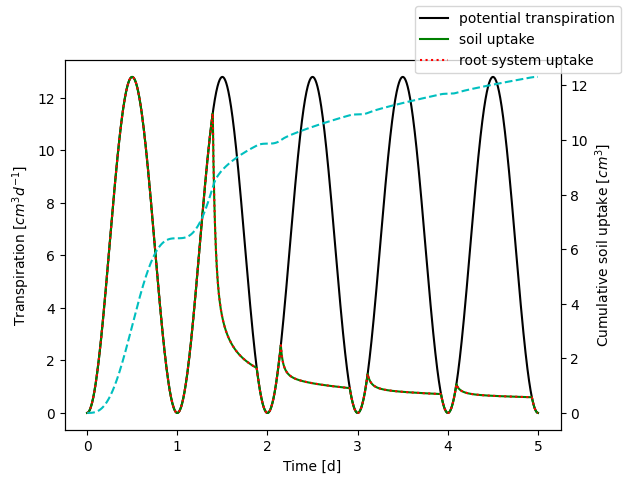

In [19]:
# s.writeDumuxVTK("dumux-rosi-example")
vp.plot_roots_and_soil(r.rs, "pressure head", rx, s, periodic, min_b, max_b, cell_number, name)
plot_transpiration(times_, soil_flux_, collar_flux_, lambda t: trans * sinusoidal(t))
# np.savetxt(name, np.vstack((times_, -np.array(soil_flux_))), delimiter=';')
# np.save("sink1d", np.array(sink1d_))

Things we can easily modify in the script
* make it periodic (there is a simulation parameter at the beginning of the jupyter notebook)
* change initial root system age
* change the soil type and initial potential 
* add root growth (put rs.simulate(dt) within the simulation loop)
* add age dependent conductivities

Where to find what, solver member functions are distributed over four files. The Python functions are for convenience and manage unit conversions and things necessary for MPI, they call the C++ part. 

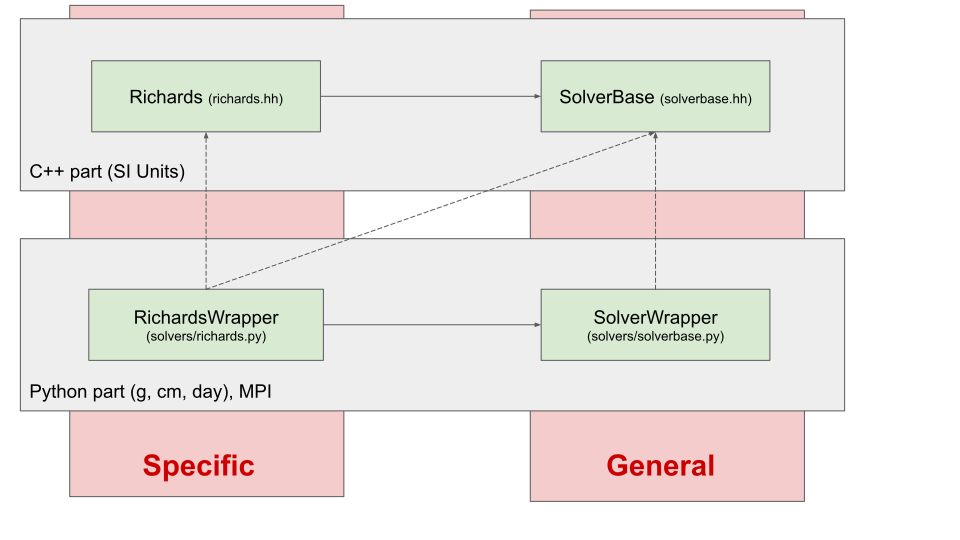

In [11]:
display(SVG(filename='dumux-rosi.svg'))

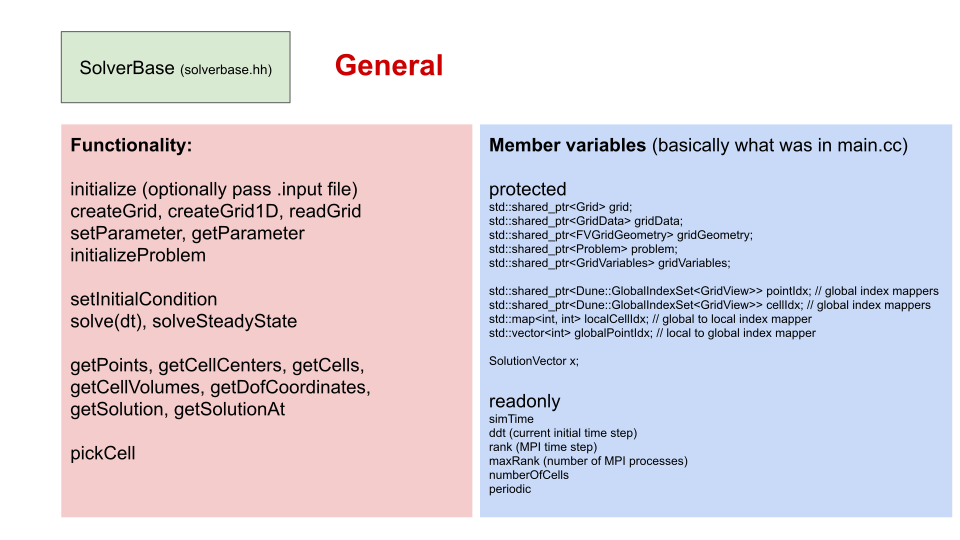

In [12]:
display(SVG(filename='dumux-rosi2.svg'))

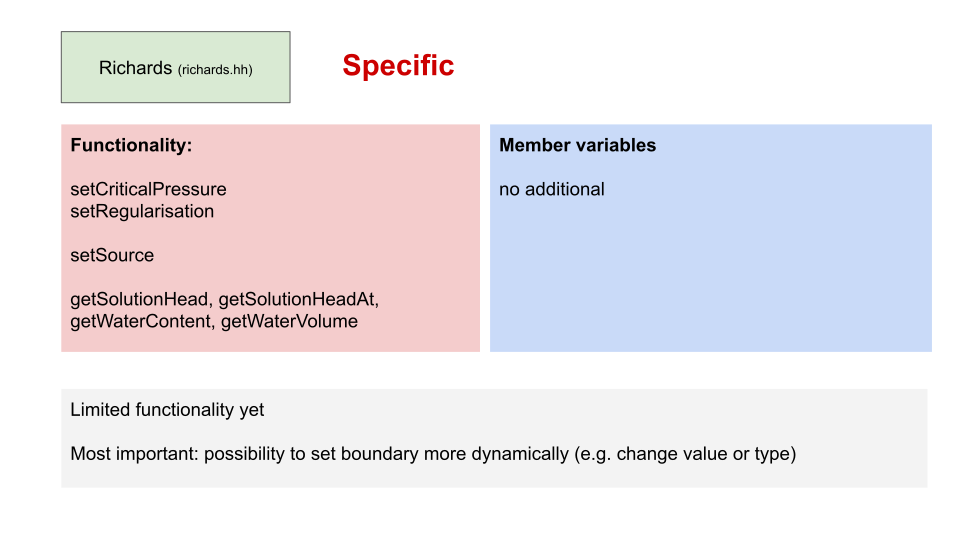

In [13]:
display(SVG(filename='dumux-rosi3.svg'))

## Take away messages

Some idea how to couple the root system simulation with DuMux using DuMux-Rosi.

## Further topics

* Parallelisation (essential if we have a finer soil resolution), DuMux uses MPI, works in DuMux-Rosi

* Where to find what in the C++ code

* Coupling to 1D axisymmetric modes, to represent the rhizosphere, e.g. Water and phosphate, TH Mai et al. (2020) Annals of Botany 

* Coupling to steady rate solutions of 1D axisymmetric Richards equation (T Schröder et al. (2008) Vadose Zone Journal; J Vanderborght et al. (2021) HESS, preprint)
